# Bayesian Changepoint Detection 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [10]:
data = generate_normal_time_series(7, 50, 200)

Let's have a look, how they look like:

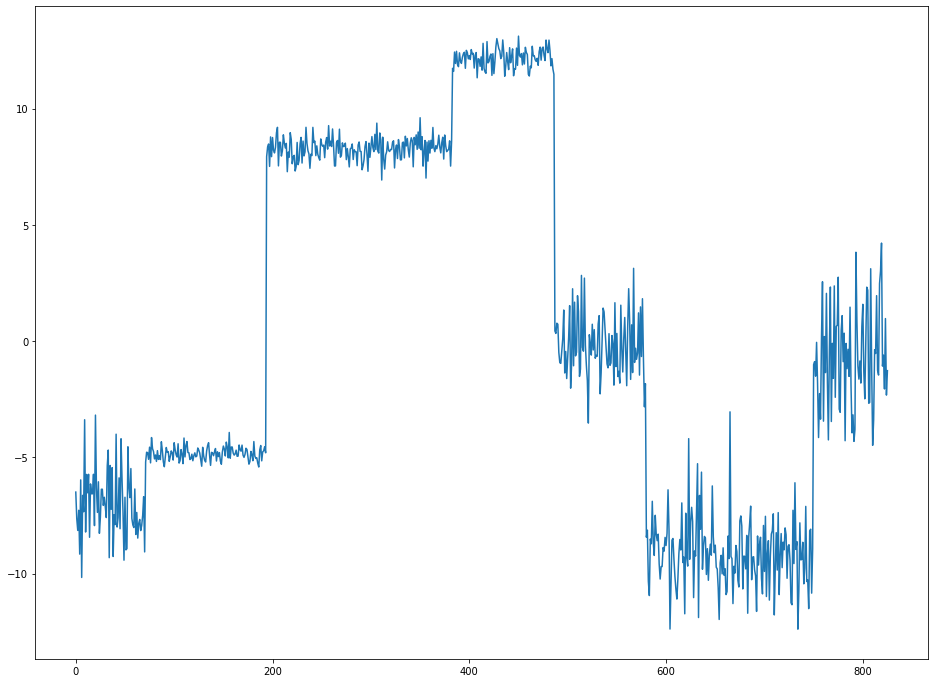

In [11]:
fig, ax = plt.subplots(figsize=[16, 12])
ax.plot(data)

## Online Changepoint Detection

Let's assume the data points come in one after another and not as these nice batches. During the process you want to know if the new point has the same hyperparameter or different ones. You need an online changepoint detection.

In [12]:
from __future__ import division

import numpy as np
from numpy.linalg import inv
from scipy import stats
from itertools import islice

def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)

    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1

    for t, x in enumerate(data):
        
        predprobs = observation_likelihood.pdf(x)
        H = hazard_func(np.array(range(t+1)))
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        observation_likelihood.update_theta(x)
        maxes[t] = R[:, t].argmax()
    return R, maxes


def constant_hazard(lam, r):
    return 1/lam * np.ones(r.shape)


class StudentT:
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        return stats.t.pdf(x=data,
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update_theta(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))

        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0

class MultivariateT:
    def __init__(self, dims, dof=None, kappa=1, mu=None, scale=None):
        if dof is None:
            dof = dims + 1
        if mu is None:
            mu = [0]*dims
        if scale is None:
            scale = np.identity(dims)
        self.t = 0
        self.dims = dims
        self.dof = np.array([dof])
        self.kappa = np.array([kappa])
        self.mu = np.array([mu])
        self.scale = np.array([scale])

    def pdf(self, data):
        self.t += 1
        t_dof = self.dof - self.dims + 1
        expanded = np.expand_dims((self.kappa * t_dof) / (self.kappa + 1), (1, 2))
        ret = np.empty(self.t)
        try:
            for i, (df, loc, shape) in islice(enumerate(zip(
                t_dof,
                self.mu,
                inv(expanded * self.scale)
            )), self.t):
                ret[i] = stats.multivariate_t.pdf(
                    x=data,
                    df=df,
                    loc=loc,
                    shape=shape
                )
        except AttributeError:
            raise Exception('You need scipy 1.6.0 or greater to use the multivariate t distribution')
        return ret

    def update_theta(self, data):
        centered = data - self.mu
        self.scale = np.concatenate([
            self.scale[:1],
            inv(
                inv(self.scale)
                + np.expand_dims(self.kappa / (self.kappa + 1), (1, 2)) * (np.expand_dims(centered, 2) @ np.expand_dims(centered, 1))
            )
        ])
        self.mu = np.concatenate([self.mu[:1], (np.expand_dims(self.kappa, 1) * self.mu + data)/np.expand_dims(self.kappa + 1, 1)])
        self.dof = np.concatenate([self.dof[:1], self.dof + 1])
        self.kappa = np.concatenate([self.kappa[:1], self.kappa + 1])
def plot(R, data):
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=[18, 16])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(data)
    ax = fig.add_subplot(2, 1, 2, sharex=ax)
    sparsity = 1  
    ax.pcolor(
        np.array(range(0, len(R[:, 0]), sparsity)),
        np.array(range(0, len(R[:, 0]), sparsity)),
        np.log(R),
        cmap=cm.Greys, vmin=-30, vmax=0
    )
    return fig

In [13]:
from functools import partial
R, maxes = online_changepoint_detection(data, partial(constant_hazard, 250), StudentT(0.1, .01, 1, 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


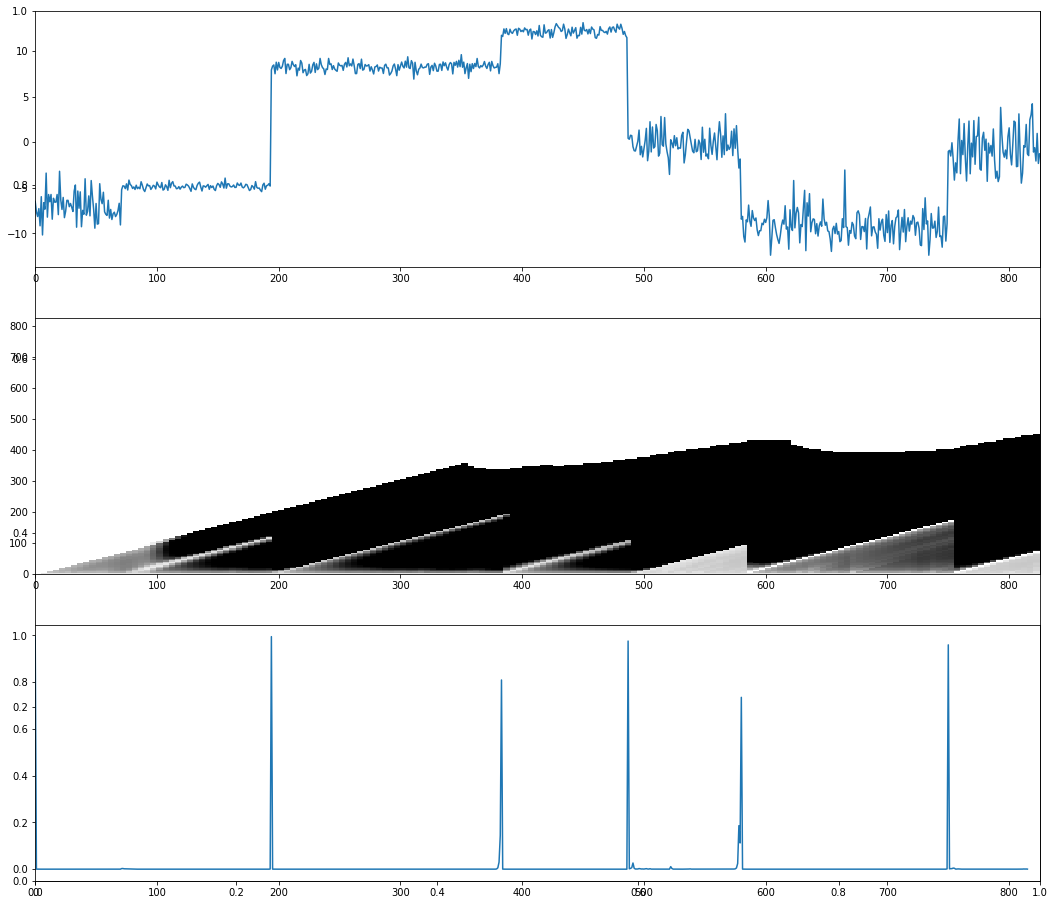

In [14]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])